---
Data Loading and Preprocessing

In [1]:
import pandas as pd

# Loads
anime_df = pd.read_parquet('Data/anilist_anime_data.parquet')
user_df = pd.read_parquet('Data/anilist_user_data.parquet')
anime_mapping_df = pd.read_parquet('Data/kaggle_animes.parquet')
ratings_df = pd.read_parquet('Data/kaggle_ratings.parquet')

In [2]:
# Renames
anime_df.rename(columns={'id': 'idAnilist'}, inplace=True) 
user_df.rename(columns={'id_mal': 'idMal',
                        'id_anilist': 'idAnilist',
                        'score': 'rating'}, inplace=True) 

In [3]:
# Remove duplicates
anime_df.drop_duplicates(subset='idMal', keep='first', inplace=True)

In [4]:
# Unpacks
anime_df['title'] = anime_df['title'].apply(lambda x: x['romaji'])
anime_df['year'] = anime_df['startDate'].apply(lambda x: x['year'])
anime_df['studio'] = anime_df['studios'].apply(lambda x: x['edges'][0]['node']['name'] if x and len(x['edges']) > 0 else 'Unknown')

In [5]:
# Fill NA
fill_values_anime = {
    'popularity':anime_df['popularity'].mean(),
    'averageScore':anime_df['averageScore'].mean(),
    'idAnilist': -1,
    'idMal': -1,
    'description': '',
    'format': 'UNKNOWN',
    'year': anime_df['year'].median(),
    'status': 'Unknown',
    'source': 'Unknown',
    'duration': 24,
    'episodes': 12,
    'countryOfOrigin': 'Unknown'
}

anime_df.fillna(fill_values_anime, inplace=True)


fill_values_user = {
    'list_name': 'Unknown',
    'status': 'Unknown',
    'rating':user_df['rating'].median(),
    'idAnilist': -1,
    'idMal': -1,
    'title': 'Unknown'
}

user_df.fillna(fill_values_user, inplace=True)


fill_values_ratings = {
    'userID': -1,
    'animeID': -1,
    'rating': ratings_df['rating'].median()
}

ratings_df.fillna(fill_values_ratings, inplace=True)

In [6]:
# Map idMal from Kaggle Data
anime_mapping_df['idMal'] = anime_mapping_df['mal_url'].str.extract(r'/anime/(\d+)').astype(int)

ratings_df = ratings_df.merge(
    anime_mapping_df[['animeID', 'idMal']],
    on='animeID',
    how='inner'
)

ratings_df = ratings_df.reset_index(drop=True).drop(columns='animeID')

In [7]:
# Filter data to match idMal
ratings_df = ratings_df[ratings_df['idMal'].isin(anime_df['idMal'])].reset_index(drop=True)
user_df = user_df[user_df['idMal'].isin(anime_df['idMal'])].reset_index(drop=True)
user_df = user_df.drop(['list_name','status', 'title'], axis=1)

In [8]:
# Map user's list to ratings
new_user_id = ratings_df['userID'].max() + 1

new_user_ratings = user_df[['idMal', 'rating']].assign(userID=new_user_id)[['userID', 'rating', 'idMal']]

ratings_df = pd.concat([ratings_df, new_user_ratings], ignore_index=True)

---
Genres

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

# Multi hot encoding
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(anime_df['genres'])
genres_cols = pd.DataFrame(genres_encoded, columns=[f'genres_{g}' for g in mlb.classes_], index=anime_df.index)
anime_df = pd.concat([anime_df, genres_cols], axis=1)


---
Tags

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# SVD 100% variance
tags = anime_df['tags'].apply(lambda x: {tag['name']: tag['rank'] for tag in x})
tags_df = pd.DataFrame(list(tags)).fillna(0)

scaler = StandardScaler()
tags_scaled = scaler.fit_transform(tags_df)

svd = TruncatedSVD(n_components=tags_df.shape[1], random_state=42)
tags_svd = svd.fit_transform(tags_scaled)

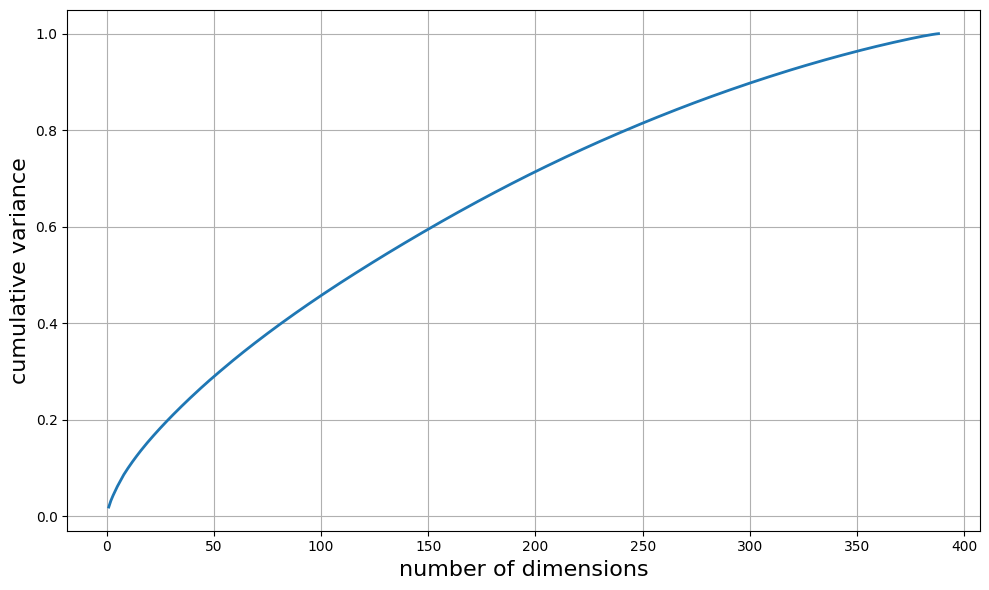

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SVD variance graph
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(10,6))
sns.lineplot(
    x=range(1, len(cumulative_variance) + 1),
    y=cumulative_variance,
    linewidth=2,
)
plt.grid()
plt.xlabel('number of dimensions', fontsize=16)
plt.ylabel('cumulative variance', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler

# SVD 80% variance
svd = TruncatedSVD(n_components=245, random_state=42)
tags_svd = svd.fit_transform(tags_scaled)

scaler = MinMaxScaler()
tags_scaled = scaler.fit_transform(tags_svd)

tags_cols = pd.DataFrame(tags_scaled, columns=[f'tags_{i}' for i in range(tags_scaled.shape[1])], index=anime_df.index)
anime_df = pd.concat([anime_df, tags_cols], axis=1)

---
Categorical

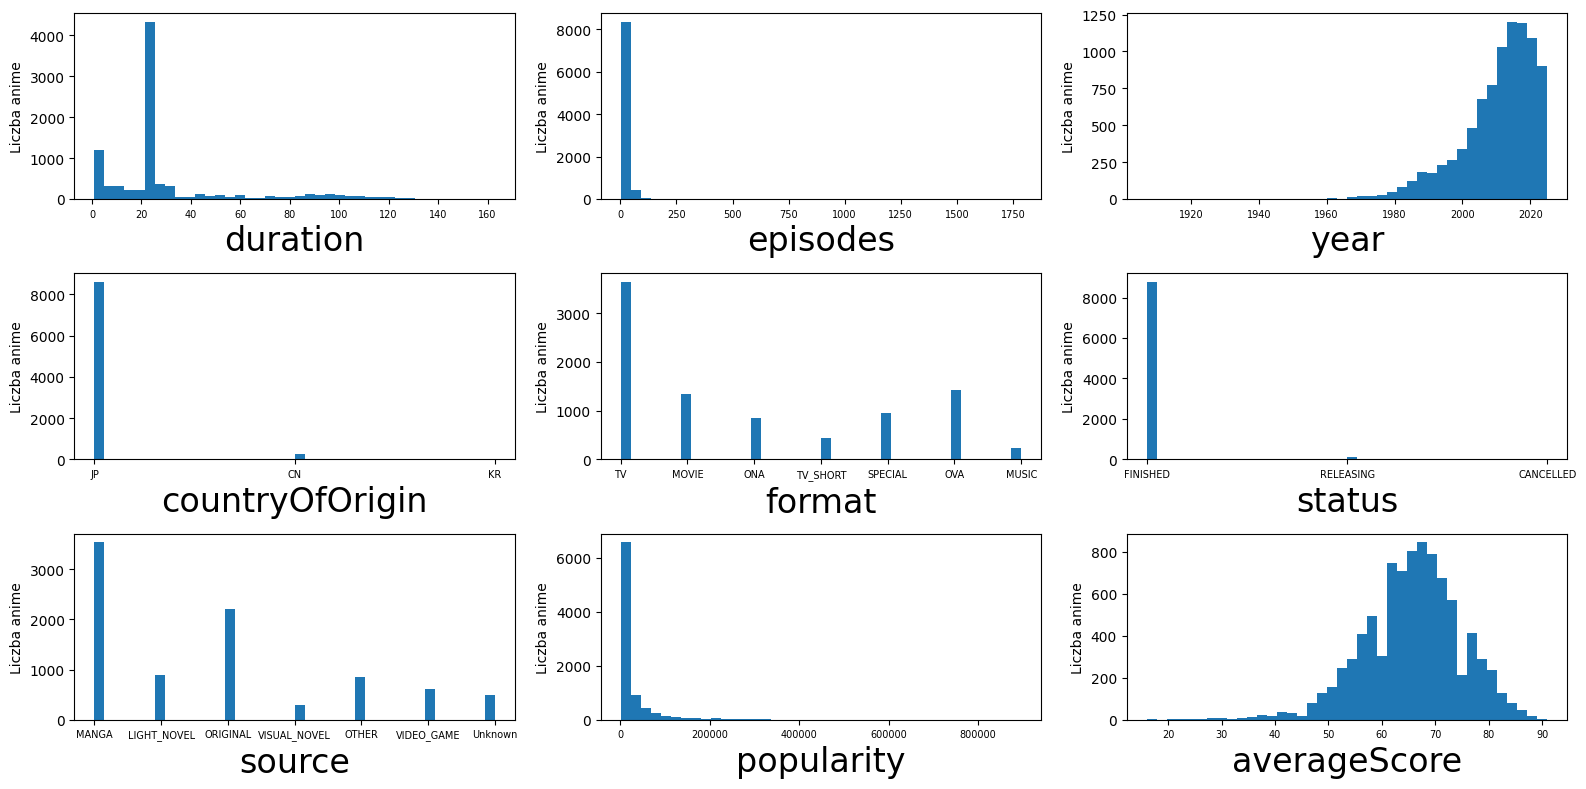

In [13]:
import matplotlib.pyplot as plt

# Catgorical data graphs
cat_cols = ['duration', 'episodes', 'year', 'countryOfOrigin', 'format', 'status', 'source', 'popularity', 'averageScore']

plt.figure(figsize=(16, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(anime_df[col].dropna(), bins=40)
    plt.xlabel(col, fontsize=24)
    plt.xticks(fontsize=7)
    plt.ylabel('Liczba anime')
plt.tight_layout()
plt.show()

In [14]:
#categorical DF
def duration_range(x):
    if x <= 16:
        return 'short'
    elif x <= 28:
        return 'standard'
    else:
        return 'long'
    

def year_range(year):
    if year < 1990:
        return 'before 1990'
    elif year < 2000:
        return '1990-1999'
    elif year < 2010:
        return '2000-2009'
    elif year < 2020:
        return '2010-2019'
    else:
        return '2020 and later'
    
    
duration_dummies = pd.get_dummies(anime_df['duration'].apply(duration_range), prefix='duration')
year_dummies = pd.get_dummies(anime_df['year'].apply(year_range), prefix='year')
format_dummies= pd.get_dummies(anime_df['format'], prefix='format')
source_dummies = pd.get_dummies(anime_df['source'], prefix='source')

anime_df = pd.concat([anime_df, duration_dummies, year_dummies, format_dummies, source_dummies], axis=1)

---
Popularity and Score

In [15]:
anime_df['popularity'] = np.log1p(anime_df['popularity'])
pop_scaler = MinMaxScaler()
anime_df['popularity'] = pop_scaler.fit_transform(anime_df[['popularity']])

score_scaler = MinMaxScaler()
anime_df['averageScore'] = score_scaler.fit_transform(anime_df[['averageScore']])

---
Descriptions

In [16]:
from sentence_transformers import SentenceTransformer

# Description transformer
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1') 
desc_embeddings = model.encode(anime_df['description'].tolist())

scaler = MinMaxScaler()
desc_scaled = scaler.fit_transform(desc_embeddings)

desc_df = pd.DataFrame(desc_scaled, columns=[f'desc_{i}' for i in range(desc_scaled.shape[1])], index=anime_df.index)
anime_df = pd.concat([anime_df, desc_df], axis=1)

c:\Users\fblac\Documents\py_proj\Anime\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
Final preprocessing

In [17]:
# Drop columns
cols_to_drop = [
    'startDate', 'studios', 'genres', 'tags', 'status', 
    'episodes', 'countryOfOrigin', 'relations', 'recommendations',
    'duration', 'year', 'format', 'source', 'description', 'studio'
]

anime_df = anime_df.drop(columns=cols_to_drop)

In [18]:
# Converts data types
anime_df['idMal'] = anime_df['idMal'].astype('int64')
float64_cols = anime_df.select_dtypes('float64').columns
anime_df[float64_cols] = anime_df[float64_cols].astype('float32')

user_df['idMal'] = user_df['idMal'].astype('int64')
ratings_df['idMal'] = ratings_df['idMal'].astype('int64')

In [ ]:
anime_df.to_parquet('Data/preprocessed_anime.parquet', index=False)
user_df.to_parquet('Data/preprocessed_user.parquet', index=False)
ratings_df.to_parquet('Data/preprocessed_ratings.parquet', index=False)